# Building a xG Model

## 1. What is xG?

In short, Expected Goals (xG) is a metric created to measure the probability of a shot turning into a goal.

An xG model uses historical data from thousands of shots with similar characteristics to estimate the probability of scoring on a scale from 0 to 1. For example, a shot with an xG of 0.3 is expected to result in a goal 30% of the time.

This doesn't necessarily mean that xG is a good metric for predicting the outcome of individual matches, but we can use it to draw some interesting conclusions. For instance, a striker who consistently performs better than their xG is an above-average finisher. Similarly, xG is a good metric for identifying which teams are more efficient at converting their chances.

## 2. Setup

To build our model we'll use data from the top 5 European leagues. The data was initially collected by [WyScout](https://wyscout.hudl.com/) and is publicly available at [Kaggle](https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset). 

We'll begin by importing some libraries and loading our data.

In [4]:
import os

os.chdir('C:\\Users\\JP Nogueira\\OneDrive - unb.br\\Mestrado\\Métodos Computacionais\\Exercício ML')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from mplsoccer import VerticalPitch
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#Abre os arquivos com eventos de cada campeonato
event1 = pd.read_csv('events_England.csv',encoding="utf-8")
event2 = pd.read_csv('events_France.csv',encoding="utf-8")
event3 = pd.read_csv('events_Germany.csv',encoding="utf-8")
event4 = pd.read_csv('events_Italy.csv',encoding="utf-8")
event5 = pd.read_csv('events_Spain.csv',encoding="utf-8")

#Junta todos os eventos num só DataFrame
events = pd.concat([event1,event2,event3,event4,event5]).reset_index(drop=True)

#Abre os arquivos com os jogos de cada campeonato
match1 = pd.read_csv('matches_England.csv')
match2 = pd.read_csv('matches_France.csv')
match3 = pd.read_csv('matches_Germany.csv')
match4 = pd.read_csv('matches_Italy.csv')
match5 = pd.read_csv('matches_Spain.csv')

#Junta todos os jogos num só DataFrame
matches = pd.concat([match1,match2,match3,match4,match5]).reset_index(drop=True)

#Importa o arquivo com dados dos jogadores
players = pd.read_csv('players.csv')

#Junta todos os DataFrames
df = pd.merge(events,players[['wyId','foot','firstName','lastName']],left_on='playerId',right_on='wyId').reset_index(drop=True)
df = pd.merge(df,matches[['wyId', 'label', 'venue', 'date']], left_on='matchId', right_on='wyId').reset_index(drop=True)
df = df.drop(columns=['wyId_x','wyId_y'])
df = df.sort_values(['matchId','matchPeriod','eventSec'])
df['previous event'] = df['subEventName'].shift(1) #Cria coluna com "evento anterior"

Our xG model will be built using only shots data, so we'll create a new Data Frame. Note that we'll not include penalty shots in our analysis as they'd create a bias in our model.

In [5]:
all_shots = df[(df['subEventName'] == 'Shot') |(df['subEventName'] =='Free kick shot')].copy().reset_index(drop=True)

Next, we need to create variables that assign coordinates to the shots. This will allow us to calculate the distance and angle of each shot. [This](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760) article explains a bit of the math behind the calculation of the shot angle, while the distance is the Euclidean distance. Additionally, we create a dummy variable indicating whether the shot resulted in a goal.

In [6]:
all_shots['positions'] = all_shots['positions'].apply(ast.literal_eval)
all_shots['tags'] = all_shots['tags'].apply(ast.literal_eval)

all_shots['Goal'] = all_shots['tags'].apply(lambda x: 1 if (any(item.get('id') == 101 for item in x)) else 0) #cria coluna com dummy para gols

enc = LabelEncoder()

enc.fit(all_shots['Goal'])
all_shots['Goal'] = enc.transform(all_shots['Goal'])

all_shots['X'] = all_shots['positions'].apply(lambda x: (100 - x[0]['x']) * 105/100)
all_shots['Y'] = all_shots['positions'].apply(lambda x: x[0]['y'] * 68/100)
all_shots["C"] = all_shots['positions'].apply(lambda x: abs(x[0]['y'] - 50) * 68/100)
all_shots["Distance"] = np.sqrt(all_shots["X"]**2 + all_shots["C"]**2)
all_shots["Angle"] = np.where(np.arctan(7.32 * all_shots["X"] / (all_shots["X"]**2 + all_shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * all_shots["X"] /(all_shots["X"]**2 + all_shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * all_shots["X"] /(all_shots["X"]**2 + all_shots["C"]**2 - (7.32/2)**2)) + np.pi)

Let us visualize what we've got so far.

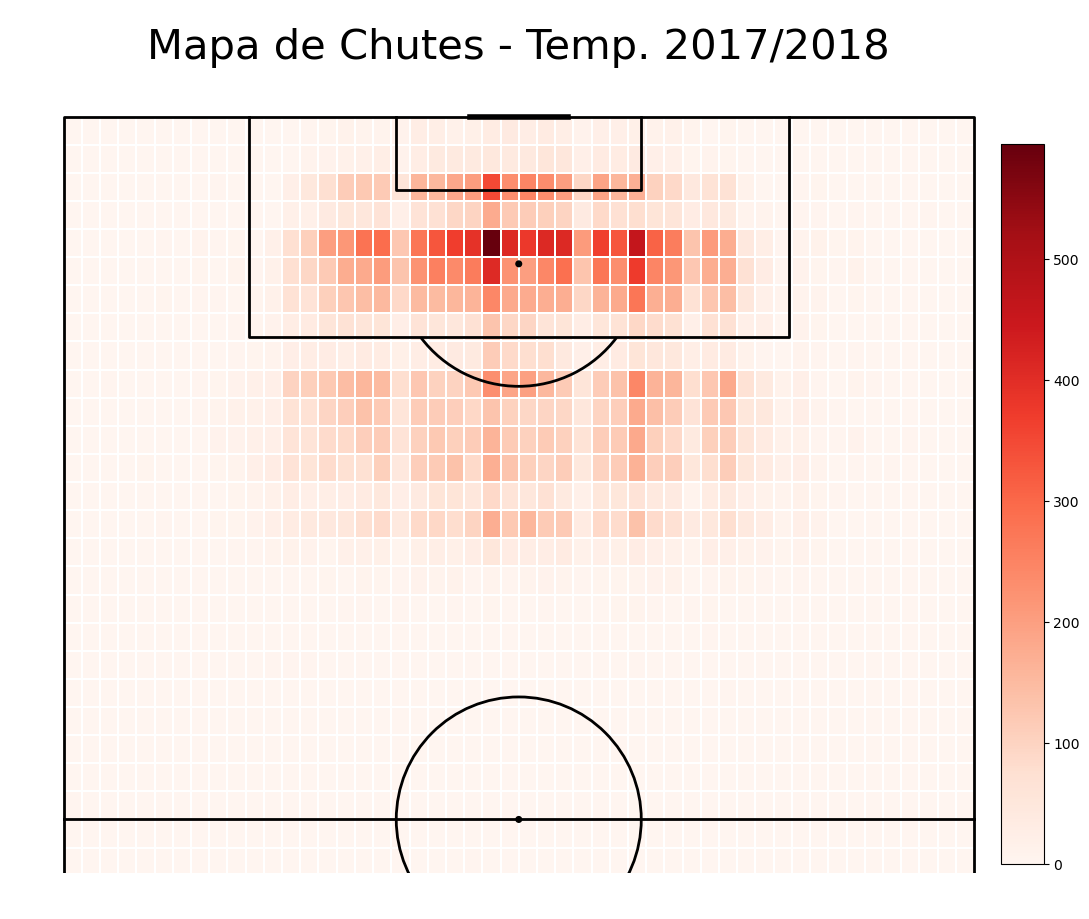

In [7]:
#Visualizando os dados até aqui
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic_shots = pitch.bin_statistic(105 - all_shots.X, all_shots.Y, bins=50)
#cria mapa de calor
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Mapa de Chutes - Temp. 2017/2018' , fontsize = 30)
plt.show()

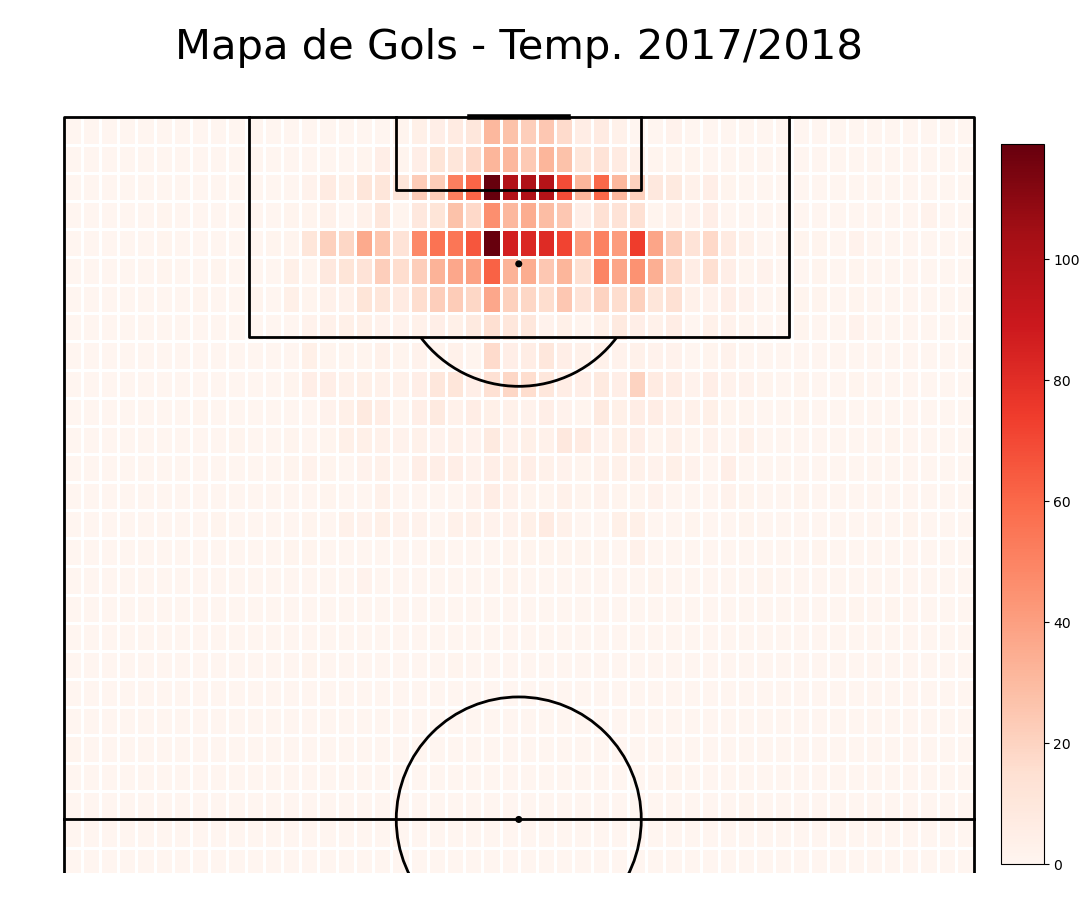

In [8]:
goals = all_shots.loc[all_shots["Goal"] == 1]
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#calcula o número de gols em cada bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Mapa de Gols - Temp. 2017/2018' , fontsize = 30)
plt.show()

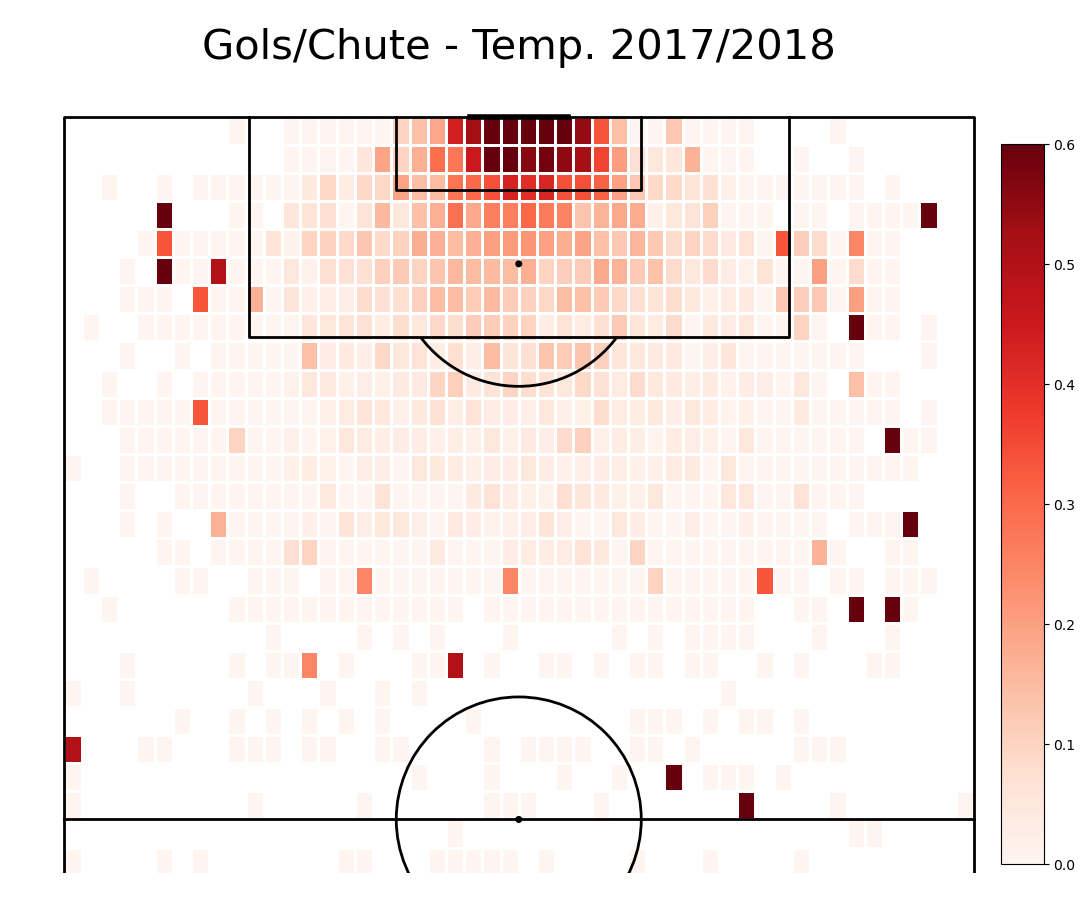

In [9]:
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - all_shots.X, all_shots.Y, bins = 50)
#Número de gols por chute
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Gols/Chute - Temp. 2017/2018' , fontsize = 30)
plt.show()

The results seem to be quite intuitive. Most of the shots and goals come from the central zone of the field. In the third figure, we have some outliers—likely because the frequency of shots is not high enough—that we will need to address.

Now, to make our model as informative as possible, let's create a few more variables.

In [12]:
all_shots['free kick'] = 1*(all_shots['subEventName'] == 'Free kick shot') #Dummy para chutes de falta
all_shots['rebound']= 1*(all_shots['previous event'] == 'Penalty') \
                    + 1*(all_shots['previous event'] == 'Free kick shot') \
                    + 1*(all_shots['previous event'] == 'Shot') \
                    + 1*(all_shots['previous event'] == 'Save attempt') #Dummy para chutes de rebote
all_shots['prev_cross'] = 1*(all_shots['previous event'] == 'Corner') \
                        + 1*(all_shots['previous event'] == 'Free kick cross') \
                        + 1*(all_shots['previous event'] == 'Cross') #Dummy para chutes que se originaram em cruzamentos
all_shots['prev_touch'] = 1*(all_shots['previous event'] == 'Touch')
all_shots['prev_pass'] = 1*(all_shots['previous event'] == 'Simple pass') \
                       + 1*(all_shots['previous event'] == 'Head pass') \
                       + 1*(all_shots['previous event'] == 'Goal kick') #Dummy para chutes que se originaram em passes
all_shots['prev_smart_pass'] = 1*(all_shots['previous event'] == 'Smart pass')
all_shots['prev_duel'] = 1*(all_shots['previous event'] == 'Air duel') \
                       + 1*(all_shots['previous event'] == 'Ground defending duel')  \
                       + 1*(all_shots['previous event'] == 'Ground attacking duel') \
                       + 1*(all_shots['previous event'] == 'Ground loose ball duel duel') #Dummy para chutes que se originaram de divididas

all_shots['left_foot'] = all_shots['tags'].apply(lambda x: 1 if (any(item.get('id') == 401 for item in x)) else 0) #dummy para chutes com o pé esquerdo
all_shots['right_foot'] = all_shots['tags'].apply(lambda x: 1 if (any(item.get('id') == 402 for item in x)) else 0) #dummy para chutes com o pé direito
all_shots['header'] = all_shots['tags'].apply(lambda x: 1 if (any(item.get('id') == 403 for item in x)) else 0) #dummy para cabeceios
all_shots['counter_attack'] = all_shots['tags'].apply(lambda x: 1 if (any(item.get('id') == 1901 for item in x)) else 0) #dummy para contra-ataques

all_shots['side_of_field'] = 1*all_shots['positions'].apply(lambda x: x[0]['y'] * 68/100 < 50) #Metade do campo de onde saiu o chute
all_shots['strong_foot'] = np.where((((all_shots['foot']=='right') & (all_shots['right_foot']==1)) | ((all_shots['foot']=='left') & (all_shots['left_foot']==1))),1,0) #Chute foi com o pé dominante?
all_shots['out_swinging'] = 1*(all_shots['side_of_field'] == 0)*(all_shots['right_foot'] == 1) \
                           + 1*(all_shots['side_of_field'] == 1)*(all_shots['left_foot'] == 1)    #Dummy para chute de pé esquerdo (direito) do lado esquerdo (direito) do campo                  
all_shots['in_swinging'] =  1*(all_shots['side_of_field'] == 0)*(all_shots['left_foot'] == 1) \
                            + 1*(all_shots['side_of_field'] == 1)*(all_shots['right_foot'] == 1) #Dummy para chute de pé esquerdo (direito) do lado direito (esquerdo) do campo.



## 3. Building our model

We will build our xG model using a Random Forest algorithm, which is one of the most common machine learning algorithms. We start by importing a few more packages and filtering the data that we will use in the model.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from sklearn.metrics import log_loss, roc_auc_score

shots_model= all_shots.drop(columns=['eventId','subEventName','tags','playerId','positions',
                                     'matchId','eventName','teamId', 'matchPeriod','eventSec',
                                     'subEventId','id','tagsList','pos_orig_y','pos_orig_x',
                                     'pos_dest_y','pos_dest_x','foot','firstName','lastName',
                                     'label','venue','date', 'previous event']).reset_index(drop=True)
shots_model = shots_model.fillna(0)               
shots_model = shots_model[shots_model['Distance']< 75] #exclui chutes de mais de 60 metros
y = shots_model['Goal'] #variável dependente
x = shots_model.drop(['Goal'],axis=1) #variáveis independentes
x.head()

,X,Y,C,Distance,Angle,free kick,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,prev_duel,left_foot,right_foot,header,counter_attack,side_of_field,strong_foot,out_swinging,in_swinging
0,12.60,27.88,6.12,14.007655,0.467241,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1
1,15.75,35.36,1.36,15.808608,0.453557,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0
2,4.20,35.36,1.36,4.414703,1.375115,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
3,19.95,22.44,11.56,23.057235,0.274666,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,26.25,20.40,13.60,29.563872,0.219665,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1


The DataFrame x contains the 20 variables that we will use to predict y (Goals). Next, we split our data into training data and test data:

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

Before running the model, however, we should note that the standard implementation of Random Forest by sklearn does not necessarily use the best hyperparameters for our data. Hyperparameters directly control the structure, function, and performance of the model, so finding the optimal values is crucial for ensuring that the model works effectively.

There are several different techniques for tuning hyperparameters. Due to computational constraints, we will implement a Randomized Search, which, given a number of iterations, selects random sets of parameters at each iteration. To implement the Randomized Search, we will perform k-fold Cross-Validation.

In [16]:
#demora pra rodar, se for reproduzir sugiro pular essa parte
random_search_model = RandomForestClassifier(random_state=13)
cv_split = KFold(n_splits=5, random_state=13, shuffle=True)
rf_hyperparam_grid={
    "n_estimators": [100, 500],
    "max_features": ['auto', 7, 10, 15],
    "min_samples_leaf": [1, 5, 20, 100],
    "min_samples_split": [2, 10, 50, 250],
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 6, 8, 10, None]
}
rf_random_search=RandomizedSearchCV(
    estimator=random_search_model,
    param_distributions=rf_hyperparam_grid,
    n_iter=200,
    scoring="neg_log_loss",
    refit=True,
    return_train_score=True,
    cv=cv_split,    
    verbose=10,
    n_jobs=-1,
    random_state=13
)
tuned_random_model = rf_random_search.fit(x_train, y_train)
tuned_random_model.best_params_ #melhores hiperparâmetros



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'n_estimators': 100,
 'min_samples_split': 250,
 'min_samples_leaf': 20,
 'max_features': 7,
 'max_depth': 8,
 'criterion': 'entropy'}

Now that we have the best hyperparameters, we evaluate the model's performance on the test set:

In [17]:
random_y_hat = tuned_random_model.predict_proba(x_test)[:,1]
print(f"The log loss of the model with Random Search is: {log_loss(y_test, random_y_hat):.3f}")
print(f"The ROC AUC score of the model with Random Search is: {roc_auc_score(y_test, random_y_hat)*100:.2f}%")

The log loss of the model with Random Search is: 0.280
The ROC AUC score of the model with Random Search is: 78.61%


**Log loss** (or logarithmic loss) and **ROC AUC** are two evaluation metrics used to measure the performance of our model. Log loss measures the model's performance by quantifying the difference between predicted probabilities and the actual observed values. The lower the log loss, the better. On the other hand, ROC AUC represents the probability that the model ranks a positive example higher than a negative example. The closer the ROC AUC is to 1, the better.

But then what? Now that we know what log loss and ROC AUC are, how do we interpret whether the values we obtain are "good"? The truth is that there is no definitive answer to this question, but we can perform some tests. First, we compare the log loss we obtained with what we would get from a model that always correctly predicts 10.34% of the goals (i.e., the average goals per shot; run `all_shots['Goal'].mean() * 100`). Then, we intentionally alter the probability of a goal for each shot and recalculate the scores.

In [18]:
print(f"Log loss of dummy: {log_loss(y_test, [0.1034]*len(y_test)):.3f}")

print(f"Currently predicted success when shooting: {np.mean(random_y_hat)*100:.2f}%")
random_y_hat_over = random_y_hat * 6
print(f"Overestimated predicted success when shooting: {np.mean(random_y_hat_over)*100:.2f}%")
print(f"Log loss w/o overestimation: {log_loss(y_test, random_y_hat):.3f}")
print(f"Log loss with overestimation: {log_loss(y_test, random_y_hat_over):.3f}")
print(f"AUC w/o overestimation: {roc_auc_score(y_test, random_y_hat)*100:.2f}%")
print(f"AUC with overestimation: {roc_auc_score(y_test, random_y_hat_over)*100:.2f}%")

Log loss of dummy: 0.336
Currently predicted success when shooting: 10.49%
Overestimated predicted success when shooting: 62.95%
Log loss w/o overestimation: 0.280
Log loss with overestimation: 5.495
AUC w/o overestimation: 78.61%
AUC with overestimation: 78.61%


In the first case, we have a much higher log loss, so we know that our model is better than one that always predicts the average. In the second case, we get an interesting result. The log loss skyrockets, but the ROC AUC remains the same. Does this mean that ROC AUC is useless? Not necessarily, but we should be cautious in its interpretation. An example of how ROC AUC can be useful is for comparing different models.

## 4. The Results

Now that we have the model, we want to generate the xG for each entry in our database. However, we want to do this using an out-of-sample prediction. Fortunately, the `cross_val_predict` function allows us to do exactly that.

In [19]:
from sklearn.model_selection import cross_val_predict

final_rf_model = RandomForestClassifier(n_estimators=500,
                                        min_samples_split=250,
                                        min_samples_leaf=5,
                                        max_features=10,
                                        max_depth=6,
                                        criterion='gini')

rf_hat = cross_val_predict(final_rf_model, x, y, cv=8, method='predict_proba')[:,-1]
rf_preds = pd.DataFrame(rf_hat,index=x.index,columns=['xG'])

Next, we combine the prediction with the data we had previously, so we can analyze our results.

In [22]:
final_df = pd.merge(rf_preds, all_shots[['firstName', 'lastName', 'label', 'venue', 'date', 'eventSec', 
                                         'matchPeriod', 'Goal', 'Distance', 'Angle', 'X', 'Y', 'C',
                                        'prev_cross', 'prev_touch', 'prev_pass', 'prev_smart_pass', 'free kick',
       'prev_duel', 'header', 'counter_attack', 'strong_foot', 'rebound']], left_index=True, 
         right_index=True,how='left')

Let's see how our model analyzes the performance of the players.

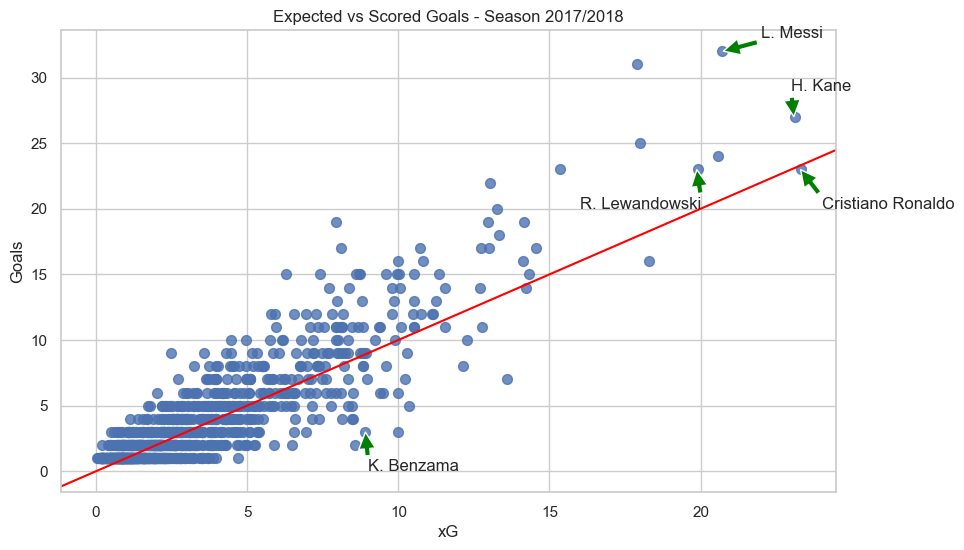

In [27]:
import seaborn as sns

xg_vs_g = final_df.drop(columns=['eventSec','matchPeriod', 'Distance', 'Angle','X','Y','C', 'prev_cross',
                              'prev_touch', 'prev_pass','prev_smart_pass', 'free kick'
                              , 'prev_duel', 'header', 'counter_attack', 'strong_foot', 'rebound',
                              'date','venue'])
xg_vs_g = xg_vs_g.groupby(['firstName','lastName','label'],sort=False,as_index=False).agg({'xG':'sum','Goal':'sum'}).reset_index(drop=True)
xg_vs_g = xg_vs_g.drop(columns=['label'])
xg_vs_g = xg_vs_g.groupby(['firstName','lastName'],as_index=False).agg({'xG':'sum','Goal':'sum'}).reset_index(drop=True)
xg_vs_g['fullName'] = xg_vs_g['firstName'] + ' ' + xg_vs_g['lastName']
xg_vs_g = xg_vs_g.drop(columns=['firstName','lastName'])
xg_vs_g = xg_vs_g.loc[xg_vs_g['Goal']>=1]

sns.set(style='whitegrid')
# Criar o scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.regplot(x='xG', y='Goal', data=xg_vs_g, scatter_kws={'s': 50},fit_reg=False)
plt.axline([0, 0], slope=1,color='red')
# Adicionar título e rótulos aos eixos
plt.title('Expected vs Scored Goals - Season 2017/2018')
plt.xlabel('xG')
plt.ylabel('Goals')
#Destaca alguns jogadores famosos
plt.annotate('L. Messi',(20.739559,32),(22,33),arrowprops=dict(facecolor ='green', 
                                  shrink = 0.01))
plt.annotate('Cristiano Ronaldo',(23.297839,23),(24,20),arrowprops=dict(facecolor ='green', 
                                  shrink = 0.01))
plt.annotate('K. Benzama',(8.911083,3),(9,0),arrowprops=dict(facecolor ='green', 
                                  shrink = 0.01))
plt.annotate('R. Lewandowski',(19.873538,23),(16,20),arrowprops=dict(facecolor ='green', 
                                  shrink = 0.01))
plt.annotate('H. Kane',(23.083823,27),(23,29),arrowprops=dict(facecolor ='green', 
                                  shrink = 0.01))
# Exibir o gráfico
plt.show()

Players above the red line exceeded their xG, meaning they scored more goals than expected. Players below the red line, on the other hand, underperformed and scored fewer goals than expected.

Next, let's see which players are the best and worst finishers according to our model.

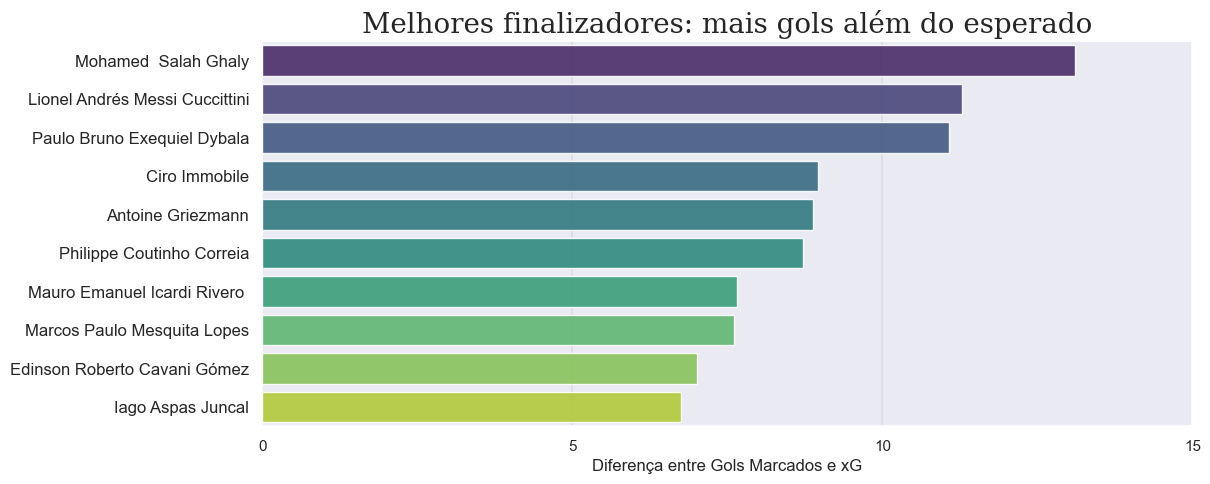

In [28]:
xg_vs_g['Diff'] = xg_vs_g['Goal'] - xg_vs_g['xG']
top_finishers = xg_vs_g.sort_values(['Diff'],ascending=False).head(10)
top_finishers['fullName'] = top_finishers['fullName'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(top_finishers['Diff']), y=top_finishers['fullName'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,20,5))
ax.set_xlabel(xlabel='Diferença entre Gols Marcados e xG', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Melhores finalizadores: mais gols além do esperado", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

Mo Salah, Leo Messi and Paulo Dybala were some of the players that outperformed our model's predicted number of goals.

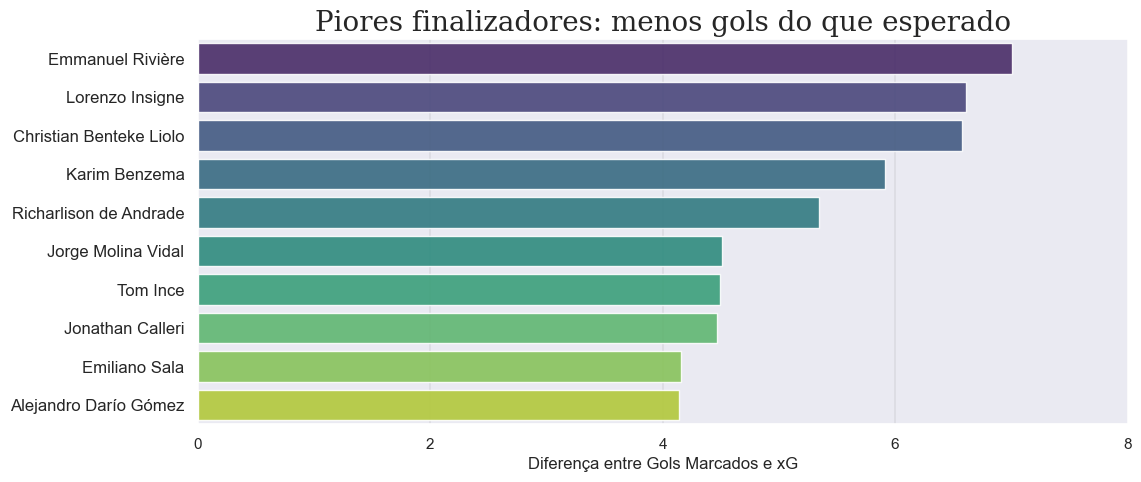

In [29]:
worst_finishers = xg_vs_g.sort_values(['Diff'],ascending=True).head(10)
worst_finishers['fullName'] = worst_finishers['fullName'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(worst_finishers['Diff']), y=worst_finishers['fullName'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,9,2))
ax.set_xlabel(xlabel='Diferença entre Gols Marcados e xG', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Piores finalizadores: menos gols do que esperado", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

Meanwhile, Emmanuel Rivière, Lorenzo Insigne and Christian Benteke underperformed.

Now, let's visualize how Manchester City performed over the entire season, according to our model.

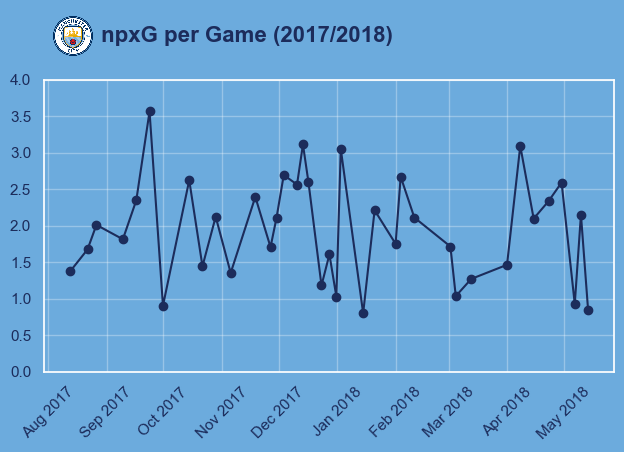

In [32]:
final_df[["team_A","team_B"]] = final_df['label'].str.split(' - ',n=1,expand=True)
final_df['team_B'] = final_df['team_B'].str.replace(r', \d+ - \d+', '', regex=True)

final_df['firstName'] = final_df['firstName'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)
final_df['lastName'] = final_df['lastName'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)

players['firstName'] = players['firstName'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)
players['lastName'] = players['lastName'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)

team_xg = final_df.drop(columns=['venue','eventSec','matchPeriod','Goal','Distance',
                                 'Angle','X','Y','C','prev_cross','prev_touch',
                                 'prev_pass','prev_smart_pass','free kick','prev_duel',
                                 'header', 'counter_attack','strong_foot','rebound'])
team_xg = team_xg.groupby(['firstName', 'lastName', 'label', 'date','team_A','team_B'])['xG'].sum().reset_index()
team_xg = team_xg.merge(players[['firstName','lastName','currentTeamId']],
                        on=['firstName','lastName'],
                        how='left')

teams = pd.read_csv('teams.csv')
teams['name'] = teams['name'].apply(lambda x: x.encode("utf-8").decode("unicode_escape") if isinstance(x, str) else x)

team_xg = team_xg.rename(columns={'currentTeamId':'wyId'})
team_xg = team_xg.merge(teams[['name','wyId']],
                        on = 'wyId',
                        how='left'
    )
team_xg = team_xg.drop(columns=['firstName','lastName'])

team_xg = team_xg.groupby(['label', 'date','team_A','team_B','name'])['xG'].sum().reset_index()

team_xg = team_xg[(team_xg['name'] == team_xg['team_A']) | (team_xg['name'] == team_xg['team_B'])]

team_xg['date'] = pd.to_datetime(team_xg['date'], utc=True) 
team_xg = team_xg.sort_values(by='date').reset_index(drop=True)

city_xg = team_xg[team_xg['name']=='Manchester City'].reset_index(drop=True)

import matplotlib.dates as mdates
import requests
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

url = "https://upload.wikimedia.org/wikipedia/pt/0/02/Manchester_City_Football_Club.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))


plt.figure(facecolor='#6CABDD')
plt.plot('date', 'xG',data=city_xg,linestyle='-',marker='o',color='#1C2C5B')
ax = plt.gca()
ax.set_facecolor('#6CABDD')  # Cor hexadecimal para o fundo
plt.grid(False, color='white', linestyle='-', alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato "Mês Ano"
plt.xticks(rotation=45,color='#1C2C5B')
plt.ylim(0,4)
plt.yticks(color='#1C2C5B')
imagebox = OffsetImage(img, zoom=0.06)  # Ajuste o zoom para redimensionar
ab = AnnotationBbox(
    imagebox,
    (0.05, 1.15),  # Posição (x, y) em coordenadas relativas (0 a 1)
    xycoords='axes fraction',
    frameon=False
)
plt.gca().add_artist(ab)
plt.text(
    0.10,  # Ajuste este valor para alinhar horizontalmente com a imagem
    1.15,   # Mesma altura vertical da imagem
    "npxG per Game (2017/2018)",  # Texto do título
    color='#1C2C5B',  # Cor do texto
    ha='left',        # Alinhamento horizontal à esquerda
    va='center',      # Alinhamento vertical centralizado
    transform=ax.transAxes,  # Usar coordenadas relativas aos eixos
    fontsize=16,
    fontweight='bold',
    fontfamily='sans-serif'
)
plt.tight_layout()
plt.show()